In [1]:
import numpy as np
import pandas as pd
import os
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:

import cv2
import os
import re
import torch
import torchvision
from torchvision import transforms 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from matplotlib import pyplot as plt
import matplotlib.axes as ax

In [3]:
WEIGHTS_FILE = "../input/fasterrcnn/fasterrcnn_resnet50_fpn_best.pth"

In [4]:
train_df = pd.read_csv("/kaggle/input/global-wheat-detection/train.csv")
submit = pd.read_csv("/kaggle/input/global-wheat-detection/sample_submission.csv")


In [5]:
train_df.head(100)

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1
...,...,...,...,...,...
95,7b72ea0fb,1024,1024,"[126.0, 464.0, 65.0, 53.0]",usask_1
96,7b72ea0fb,1024,1024,"[363.0, 262.0, 68.0, 145.0]",usask_1
97,7b72ea0fb,1024,1024,"[912.0, 656.0, 97.0, 76.0]",usask_1
98,7b72ea0fb,1024,1024,"[182.0, 97.0, 92.0, 84.0]",usask_1


In [6]:
#Dropping unwanted columns
train_df=train_df.drop(columns=['width','height','source'])


In [7]:
train_df['image_id'].nunique() 
# There are total 3373 unique image in training dataset


3373

In [8]:
(train_df['image_id'].value_counts()).max()
# maximum number of bounding boxes in a single image are 116


116

In [9]:
(train_df['image_id'].value_counts()). min() 
# Minimum number of bounding box in a single image is 1


1

In [10]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1


def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r    

In [11]:
train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x))) ##Lets convert the Box in 


In [12]:
train_df['x'] = train_df['x'].astype(np.float)                                        #in our desired formate    
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

In [13]:
train_df.head()

,image_id,bbox,x,y,w,h
0,b6ab77fd7,"[834.0, 222.0, 56.0, 36.0]",834.0,222.0,56.0,36.0
1,b6ab77fd7,"[226.0, 548.0, 130.0, 58.0]",226.0,548.0,130.0,58.0
2,b6ab77fd7,"[377.0, 504.0, 74.0, 160.0]",377.0,504.0,74.0,160.0
3,b6ab77fd7,"[834.0, 95.0, 109.0, 107.0]",834.0,95.0,109.0,107.0
4,b6ab77fd7,"[26.0, 144.0, 124.0, 117.0]",26.0,144.0,124.0,117.0


In [14]:
# Splitting the dataset into train and validation

In [15]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]


In [16]:
#Apply transform to image 
trans = transforms.Compose([transforms.ToTensor()])

Creating a Custom Dataset


In [17]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None,train=True):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.train=train

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms is not None:  #Apply transformation
            image = self.transforms(image)
        if(self.train==False):  # For test data
            return image, image_id
        #Else for train and validation data
        records = self.df[self.df['image_id'] == image_id]   
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        return image, target,image_id  

In [18]:
train_dir = "../input/global-wheat-detection/train"
test_dir = "../input/global-wheat-detection/test"

In [19]:
class Averager:      #Returns the average loss 
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
        
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, train_dir, trans,True)
valid_dataset = WheatDataset(valid_df, train_dir, trans,True)


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


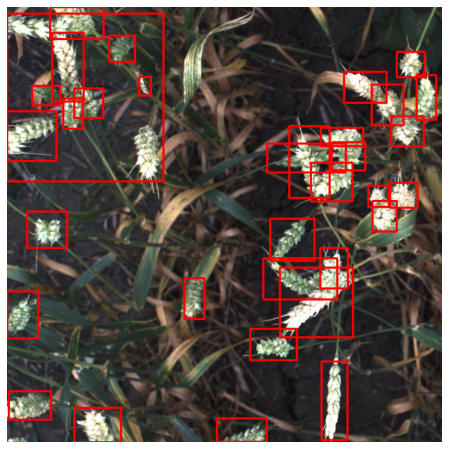

In [21]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[4]['boxes'].cpu().numpy().astype(np.int32)
sample = images[4].permute(1,2,0).cpu().numpy().copy()  #Without using .copy(), there will be an error, the reason for which according to Stackoverflow, only God and Gary Bradski know

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (int(box[0]), int(box[1])),
                  (int(box[2]), int(box[3])),
                  (220, 0, 0),3)
    
ax.set_axis_off()
ax.imshow(sample)

In [22]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

In [23]:
num_classes = 2  # =wheat and background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE))  ##Load pre trained weights
#model.eval()

#x = model.to(device)

<All keys matched successfully>

In [24]:
model.train()
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.00001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
#lr_scheduler = None

num_epochs = 5

loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)   ##Return the loss

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)  #Average out the loss

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")

Iteration #50 loss: 0.9150490760803223
Iteration #100 loss: 0.7012906670570374
Iteration #150 loss: 0.7127406597137451
Epoch #0 loss: 0.7849362268167384
Iteration #200 loss: 0.8063559532165527
Iteration #250 loss: 0.7146717309951782
Iteration #300 loss: 0.6313291192054749
Epoch #1 loss: 0.7831943648702958
Iteration #350 loss: 0.7443020939826965
Iteration #400 loss: 0.8533759117126465
Iteration #450 loss: 0.5420883893966675
Iteration #500 loss: 0.7610716223716736
Epoch #2 loss: 0.7749096572399139
Iteration #550 loss: 0.7955118417739868
Iteration #600 loss: 0.8424180150032043
Iteration #650 loss: 0.8538055419921875
Epoch #3 loss: 0.7638690433081459
Iteration #700 loss: 0.9123711585998535
Iteration #750 loss: 0.8827970027923584
Iteration #800 loss: 0.6235683560371399
Iteration #850 loss: 0.6467118263244629
Epoch #4 loss: 0.7558968978769639


In [25]:
#loading the test data
test_dataset = WheatDataset(submit,test_dir,trans, False)
test_data_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [26]:
# Setting the threshold value for predicting bounding box
detection_threshold = 0.45

In [27]:
def format_prediction_string(boxes, scores): ## Define the format for storing prediction results
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [28]:
#Defining the format for storinng prediction results
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    
    return " ".join(pred_strings)

In [29]:
#Making the prediction
results=[]
model.eval()
 
for images, image_ids in test_data_loader:
    
    images = list(image.to(device) for image in images)
    outputs = model(images)
    
    for i, image in enumerate(images):
        boxes = outputs[i]['boxes'].data.cpu().numpy()  #[Xmin,Ymin,Xmax,Ymax]
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        
        image_id = image_ids[i]
        
        #converting the box format to [Xmin,Ymin,W,H]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]         
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1] 
        
        #Storing the image id and boxes and scores in result dict
        
        result = {                                     
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)}
          
        #Appending the result dict to results list
        results.append(result)   

In [30]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,aac893a91,0.9955 556 527 130 187 0.9915 613 909 80 110 0...
1,51f1be19e,0.9972 600 73 169 184 0.9920 501 453 209 116 0...
2,f5a1f0358,0.9931 540 264 112 112 0.9929 935 416 88 195 0...
3,796707dd7,0.9915 939 58 84 109 0.9891 33 76 170 132 0.98...
4,51b3e36ab,0.9955 832 443 189 148 0.9955 692 606 329 136 ...


In [31]:
sample = images[1].permute(1,2,0).cpu().numpy().copy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

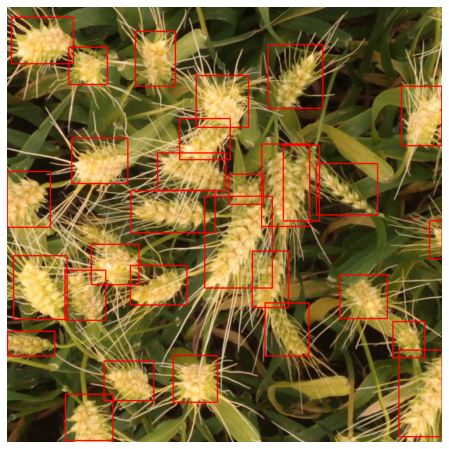

In [32]:
# plotting some of the predictions

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (int(box[0]), int(box[1])),
                  (int(box[2]), int(box[3])),
                  (220, 0, 0), 2)
ax.set_axis_off()
ax.imshow(sample)

In [33]:
test_df.to_csv('submission.csv', index=False)